In [109]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

In [110]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

def mode_time_scale_theory(n: int, R: float, Cm: float, Cs: float, N: int)->float:
    """Characteristic Time of mode n in a string of N Nanoparticles

    Parameters
    ----------
    n : int
        nth mode [1,N]
    R : float
        Junction resistance
    Cm : float
        Mutual capacitance
    Cs : float
        Self capacitance
    N : int
        Number of Nanoparticles in String

    Returns
    -------
    float
        Mode time scale
    """
    a   = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
    b   = 2*(1-np.cos(n*np.pi/(N+1)))
    return a/b

def solve_a_values(U0: float, N: int)->np.ndarray:

    S = np.array([
        [np.sin(n * np.pi * i / (N + 1)) for n in range(1, N + 1)]
        for i in range(1, N + 1)
    ])

    # Construct the right-hand side vector b
    b = np.array([-U0 * (1 - i / (N + 1)) for i in range(1, N + 1)])

    # Solve the linear system S * a = b
    a = np.linalg.solve(S, b)

    return a

def node_potential(t_values: np.ndarray, a_n: np.ndarray, tau_n: np.ndarray, U0: float):
    
    N = len(a_n)
    i_values = np.arange(1, N + 1)[:, None]  # Shape (N, 1)
    t_values = np.array(t_values)[None, :]  # Shape (1, T)

    # First term: U0 * (1 - i / (N + 1)) for each i
    steady_part = U0 * (1 - i_values / (N + 1))  # Shape (N, 1)

    # Precompute sin matrix: sin(n * pi * i / (N+1))
    sin_matrix = np.array([
        [np.sin(n * np.pi * i / (N + 1)) for n in range(1, N + 1)]
        for i in range(1, N + 1)
    ])  # Shape (N, N)

    # Exponential decay for each n and each t
    exp_decay = np.exp(-t_values / tau_n[:, None])  # Shape (N, T)

    # Multiply a_n * exp_decay for each n, then sum over n weighted by sin
    dynamic_part = sin_matrix @ (a_n[:, None] * exp_decay)  # Shape (N, T)

    # Add steady part (broadcasted) and return full U(i, t)
    U = steady_part + dynamic_part  # Shape (N, T)
    return U  # Each row: i, each column: time

def particle_time_scales(a_n: np.ndarray, tau_n: np.ndarray, N: int, method='squared'):

    i_values    = np.arange(1, N + 1)
    sin_matrix  = np.array([
        [np.sin(n * np.pi * i / (N + 1)) for n in range(1, N + 1)]
        for i in i_values
    ])  # shape (N, N)

    weights = a_n * sin_matrix  # shape (N, N)

    if method == 'abs':
        weights = np.abs(weights)
    elif method == 'squared':
        weights = weights ** 2

    numerator = np.sum(weights * tau_n, axis=1)  # shape (N,)
    denominator = np.sum(weights, axis=1)        # shape (N,)
    
    tau_i = numerator / denominator
    return tau_i

In [111]:
# Parameters
N_steps = 40000
Np      = 50
R       = 25*1e6
U0      = 1.0
Cm      = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs      = self_capacitance_sphere(3.9, 10)
n_v     = np.arange(1,Np+1)
tau_n   = mode_time_scale_theory(n_v, R, Cm, Cs, Np)
a_vals  = solve_a_values(U0, Np)
t_vals  = np.arange(N_steps)*1e-10
tau_i   = particle_time_scales(a_vals, tau_n, Np)
phi     = node_potential(t_vals, a_vals, tau_n, U0)

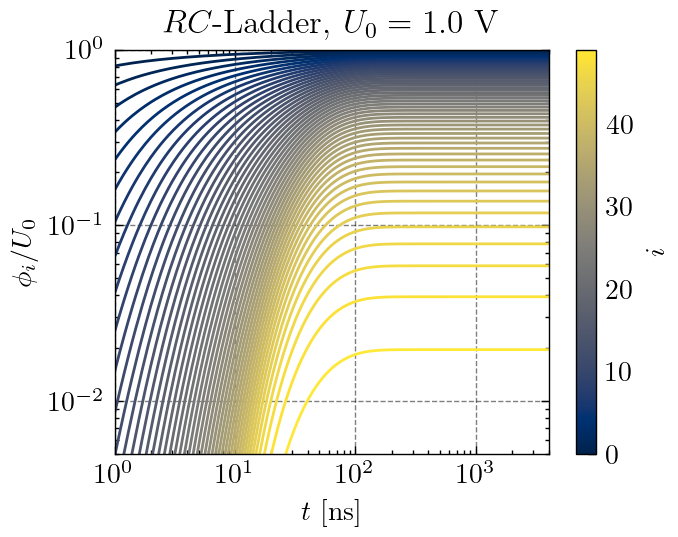

In [112]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)

for i in range(Np):
    ax.plot(t_vals*1e9, phi[i,:]/U0, color=cm(norm(i)))

ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_title(f"$RC$-Ladder, $U_0 = {U0}$ V")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

Text(0.5, 0, '$n$')

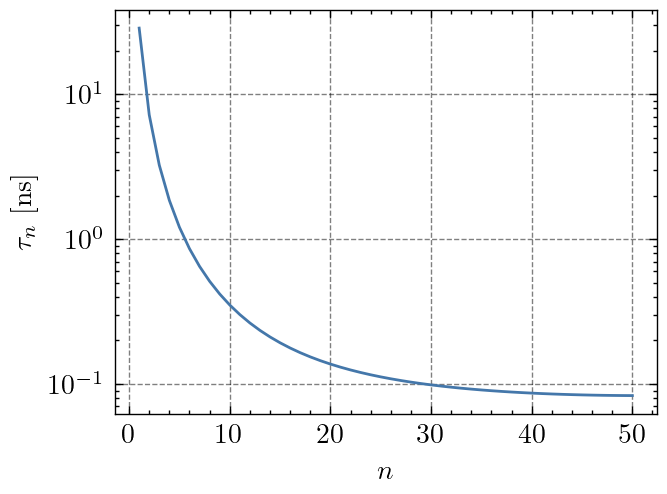

In [113]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(n_v,tau_n*1e9)
ax.set_yscale('log')
ax.set_ylabel("$\\tau_n$ [ns]")
ax.set_xlabel("$n$")

Text(0.5, 0, '$n$')

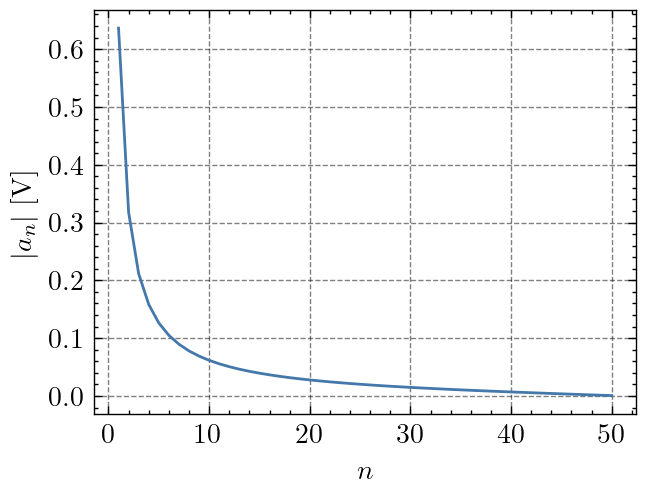

In [114]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(n_v,np.abs(a_vals))
ax.set_ylabel("$|a_n|$ [V]")
ax.set_xlabel("$n$")

Text(0.5, 0, '$i$')

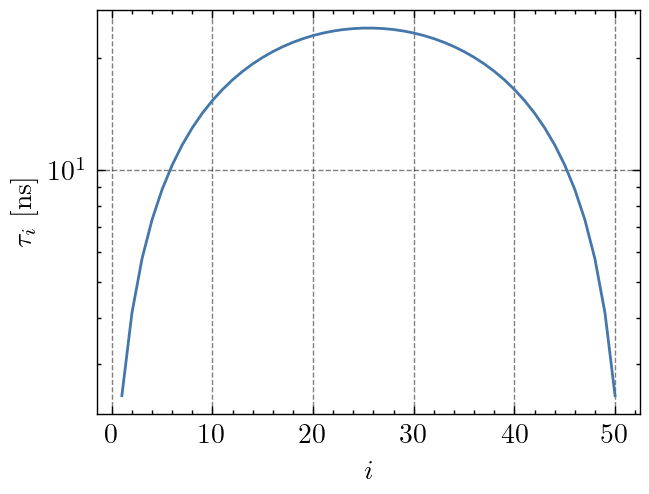

In [116]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(n_v, tau_i*1e9)
ax.set_yscale('log')
ax.set_ylabel("$\\tau_i$ [ns]")
ax.set_xlabel("$i$")